In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder,RobustScaler
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import cross_val_score,KFold,train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV
from skopt.space import Categorical
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm
import warnings


In [5]:
df = pd.read_csv("TitanicDF.csv")
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
warnings.filterwarnings("ignore", category=Warning, module="lightgbm")


# Objective
The goal of this machine learning model is to outperform a simple approach that classifies all women as survivors and all men as deceased, based on our exploratory data analysis. While this initial approach provides a straightforward baseline, our aim is to develop a more sophisticated and accurate model that takes into account various passenger characteristics, such as age, social class, ticket fare, among other variables, to more precisely predict the likelihood of survival for each individual.

Our model will be evaluated using metrics such as accuracy, recall, F1-score, and AUC-ROC, aiming not only for an improvement in accuracy but also for a balanced approach that accounts for potential class imbalances between survivors and non-survivors. By applying advanced machine learning techniques such as logistic regression, decision trees, random forests, and ensemble models, we expect to achieve a robust model that surpasses the initial baseline.

In [6]:
objective = round((df.loc[(df["Sex"]=="female") & (df["Survived"]==1),:].count()[0] + df.loc[(df["Sex"]=="male") & (df["Survived"]==0),:].count()[0]) / len(df) * 100,2)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18576\36471988.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  objective = round((df.loc[(df["Sex"]=="female") & (df["Survived"]==1),:].count()[0] + df.loc[(df["Sex"]=="male") & (df["Survived"]==0),:].count()[0]) / len(df) * 100,2)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_18576\36471988.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  objective = round((df.loc[(df["Sex"]=="female") & (df["Survived"]==1),:].count()[0] + df.loc[(df["Sex"]=="male") & (df["Survived"]==0),:].count()[0]) / len(df) * 100,2)


In [7]:
print(f'Our objective: {objective}%')

Our objective: 78.68%


# Cleaning the Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
pd.DataFrame(round(df.isnull().sum()/df.count()[0],3),columns=['% of Nulls'])

C:\Users\Lucas\AppData\Local\Temp\ipykernel_16988\2168987199.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.DataFrame(round(df.isnull().sum()/df.count()[0],3),columns=['% of Nulls'])


,% of Nulls
PassengerId,0.000
Survived,0.000
Pclass,0.000
Name,0.000
Sex,0.000
Age,0.199
SibSp,0.000
Parch,0.000
Ticket,0.000
Fare,0.000


In [8]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


Looking at the columns, we can see that some of them are not useful to us, such as Name, Ticket, and Passenger ID. It would be interesting to include the Cabin column, as the cabin's location could potentially improve predictions—cabins closer to the lifeboats might have a higher survival probability. However, due to the high number of missing values in the Cabin column, it is not practical to include it in our prediction model.

In [9]:
df.drop(['Cabin','Ticket','Name','PassengerId'],axis=1,inplace=True)

About 20% of the age values are missing. I don't believe eliminating all the null values is ideal, so I replaced the missing values with the median. Additionally, we applied the median based on the passenger's class, as some classes had younger passengers. I believe this was the best way to preserve the data's integrity as much as possible.

In [10]:
df.groupby('Pclass')['Age'].median()

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

In [11]:
df.groupby('Pclass')['Age'].median()[1]

37.0

In [12]:
df.loc[(df['Pclass']==3) & (df['Age'].isnull()),'Age'] = df.groupby('Pclass')['Age'].median()[3]
df.loc[(df['Pclass']==2) & (df['Age'].isnull()),'Age'] = df.groupby('Pclass')['Age'].median()[2]
df.loc[(df['Pclass']==1) & (df['Age'].isnull()),'Age'] = df.groupby('Pclass')['Age'].median()[1]

In [13]:
df = df.drop(df.loc[df['Embarked'].isnull(),:].index,axis=0)

In [14]:
target = df['Survived'].values
df.drop('Survived',axis=1,inplace=True)


Now, we will drop the 0.2% of missing values in the embarked column. Since these are very few entries, it will not affect our analysis.

Additionally, I will start a preprocessing step here, as I plan to drop the column shortly afterward.

## PreProcessing

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder,RobustScaler
kfold = KFold(n_splits=20,random_state=0,shuffle=True)

In [16]:
scaler = StandardScaler()
scaler2 = RobustScaler()
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])
df3 = df.copy()


In [17]:
df['Age'] = scaler.fit_transform(df.iloc[:,3:4])
df['Fare'] = scaler.fit_transform(df.iloc[:,6:7])

We need to use the StandardScaler, as we previously observed a magnitude difference between the Age and Fare columns. This difference could cause our machine learning model to prioritize the Fare column, potentially harming its performance.

Additionally, it was necessary to use a LabelEncoder to convert our categorical variables into numerical ones.

In [18]:
transformer = ColumnTransformer(
    transformers=[
        ('OneHot', OneHotEncoder(sparse_output=False), ['Pclass', 'Sex','Embarked']),
        ('RobustScaler',RobustScaler(),['SibSp','Parch'])
    ],
    remainder='passthrough',
)

In [19]:
predict1 = (transformer.fit_transform(df))

In [20]:
predict2 = df.iloc[:,1::].values

In [21]:
predict3 = df3.values

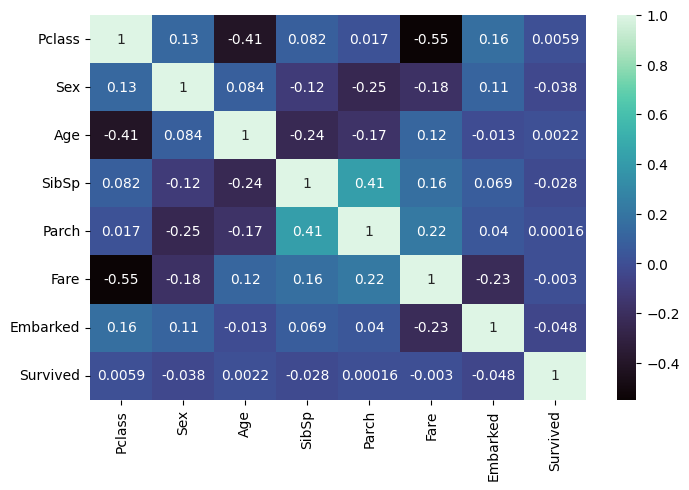

In [22]:
df4 = pd.concat([df3,pd.DataFrame(target,columns=["Survived"])],axis=1)
fig = plt.figure(figsize=(8,5))
sns.heatmap(df4.corr(method='pearson'),annot=True,cmap="mako");

To compare at the end, we will use the scaled features and the following attribute transformations:

- Predict1: OneHot encoding for Pclass, Sex, and Embarked. RobustScaler for SibSp and Parch. StandardScaler for Age and Fare.
- Predict2: LabelEncoder for Sex and Embarked. StandardScaler for Age and Fare.
- Predict3: LabelEncoder for Sex and Embarked.

# Experimentation Process with Estimators
For the experimentation process, we selected 10 different models with the goal of evaluating which one adapts best to our dataset. Among these models, some tend to increase variance while reducing error, and vice versa. Additionally, we have models that handle imbalanced classes more effectively. Although, in our case, the imbalance between the classes is not very pronounced (even though there are more deaths, the difference is not that significant), it is important to consider how the models perform in such situations.

One important consideration is that some of the selected models are distance-based, such as KNN (K-Nearest Neighbors) and Support Vector Machine (SVM). Distance-based models, like KNN, calculate similarity between data points based on proximity, which can be sensitive to the scaling of the variables. If the variables are not properly scaled, it can lead to inaccurate or distorted models, as the algorithms may be influenced by differences in units of measure or the magnitude of the values of the variables. Therefore, these predictors need to be carefully analyzed, especially if the data was not pre-processed properly.

**Selected Estimators and Their Characteristics**

Naive Bayes: This is a simple and easily interpretable model, with low sensitivity to irrelevant variables. It does not require large volumes of data, which is an advantage in our case since we have a relatively small dataset. However, a disadvantage of Naive Bayes is that it assumes independence between variables (columns). In many scenarios, this can be a limitation, but in our case, the correlation between variables is relatively low, with the strongest correlation being around -0.55. This means that the assumption of independence should not significantly harm the model’s performance, but it should still be considered when evaluating its accuracy.

Support Vector Machine (SVM) and KNN: These models were included mainly to understand how they behave with our data. As mentioned, some variables were not scaled, which can affect the performance of distance-based algorithms. If the scaling is not appropriate, KNN may generate an inaccurate model since it directly relies on the distances between data points. Additionally, we wanted to assess the robustness of Support Vector Machine (SVM) to outliers. SVM tends to be sensitive to outliers, but it can also be effective in identifying patterns in more complex data, as long as proper regularization is applied.

**Other Estimators Selected**
- Logistic Regression
- Random Forest Classifier
- Gradient Boosting
- Decision Tree Classifier
- XGBoost
- LightGBM
- Neural Classifier

## Gaussian Naive Bayes

In [23]:
result1 = pd.DataFrame(columns=['Model','TrainScore','AccuracyScore','CrossValScore'])
result2 = pd.DataFrame(columns=['Model','TrainScore','AccuracyScore','CrossValScore'])
result3 = pd.DataFrame(columns=['Model','TrainScore','AccuracyScore','CrossValScore'])
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
gb = GaussianNB()
gb.fit(x_train,y_train)
result1.loc[0] = ['Gaussian NB',accuracy_score(y_train,gb.predict(x_train)),accuracy_score(y_test,gb.predict(x_test)),cross_val_score(gb,predict1,target,scoring='roc_auc',cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
gb.fit(x_train,y_train)
result2.loc[0] = ['Gaussian NB',accuracy_score(y_train,gb.predict(x_train)),accuracy_score(y_test,gb.predict(x_test)),cross_val_score(gb,predict2,target,scoring='roc_auc',cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
gb.fit(x_train,y_train)
result3.loc[0] = ['Gaussian NB',accuracy_score(y_train,gb.predict(x_train)),accuracy_score(y_test,gb.predict(x_test)),cross_val_score(gb,predict3,target,scoring='roc_auc',cv=kfold).mean()]

## Maquina Vetor

In [24]:

x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
sv = SVC(C=1,kernel='rbf')
sv.fit(x_train,y_train)
result1.loc[1] = ['Support Vector Machine',accuracy_score(y_train,sv.predict(x_train)),accuracy_score(y_test,sv.predict(x_test)),cross_val_score(sv,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
sv = SVC(C=1,kernel='rbf')
sv.fit(x_train,y_train)
result2.loc[1] = ['Support Vector Machine',accuracy_score(y_train,sv.predict(x_train)),accuracy_score(y_test,sv.predict(x_test)),cross_val_score(sv,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
sv = SVC(C=1,kernel='linear')
sv.fit(x_train,y_train)
result3.loc[1] = ['Support Vector Machine',accuracy_score(y_train,sv.predict(x_train)),accuracy_score(y_test,sv.predict(x_test)),cross_val_score(sv,predict3,target,cv=kfold).mean()]

## KNN

In [25]:
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
knn = KNeighborsClassifier(n_neighbors=20,leaf_size=5,p=1)
knn.fit(x_train,y_train)
result1.loc[2] = ['KNN',accuracy_score(y_train,knn.predict(x_train)),accuracy_score(y_test,knn.predict(x_test)),cross_val_score(knn,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
knn = KNeighborsClassifier(n_neighbors=40,leaf_size=18,p=4)
knn.fit(x_train,y_train)
result2.loc[2] = ['KNN',accuracy_score(y_train,knn.predict(x_train)),accuracy_score(y_test,knn.predict(x_test)),cross_val_score(knn,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
knn = KNeighborsClassifier(n_neighbors=11,leaf_size=8,p=1)
knn.fit(x_train,y_train)
result3.loc[2] = ['KNN',accuracy_score(y_train,knn.predict(x_train)),accuracy_score(y_test,knn.predict(x_test)),cross_val_score(knn,predict3,target,cv=kfold).mean()]




## Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
tree2 = DecisionTreeClassifier(criterion='entropy',max_depth=3,random_state=0)
tree2.fit(x_train,y_train)
result1.loc[3] = ['Decision Tree',accuracy_score(y_train,tree2.predict(x_train)),accuracy_score(y_test,tree2.predict(x_test)),cross_val_score(tree2,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
tree2 = DecisionTreeClassifier(criterion='log_loss',max_depth=4,random_state=0)
tree2.fit(x_train,y_train)
result2.loc[3] = ['Decision Tree',accuracy_score(y_train,tree2.predict(x_train)),accuracy_score(y_test,tree2.predict(x_test)),cross_val_score(tree2,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
tree2 = DecisionTreeClassifier(criterion='log_loss',max_depth=3,random_state=0)
tree2.fit(x_train,y_train)
result3.loc[3] = ['Decision Tree',accuracy_score(y_train,tree2.predict(x_train)),accuracy_score(y_test,tree2.predict(x_test)),cross_val_score(tree2,predict3,target,cv=kfold).mean()]

## Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier()
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
treer = RandomForestClassifier(n_estimators=51,criterion='log_loss',max_depth=3,max_features='log2')
treer.fit(x_train,y_train)
result1.loc[4] = ['Random Forest',accuracy_score(y_train,treer.predict(x_train)),accuracy_score(y_test,treer.predict(x_test)),cross_val_score(treer,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
treer = RandomForestClassifier(n_estimators=52,criterion='entropy',max_depth=2,max_features='log2')
treer.fit(x_train,y_train)
result2.loc[4] = ['Random Forest',accuracy_score(y_train,treer.predict(x_train)),accuracy_score(y_test,treer.predict(x_test)),cross_val_score(treer,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
treer = RandomForestClassifier(n_estimators=147,criterion='entropy',max_depth=4,max_features='sqrt')
treer.fit(x_train,y_train)
result3.loc[4] = ['Random Forest',accuracy_score(y_train,treer.predict(x_train)),accuracy_score(y_test,treer.predict(x_test)),cross_val_score(treer,predict3,target,cv=kfold).mean()]

In [29]:
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)

## XGBoost

In [30]:
from xgboost import XGBClassifier

In [31]:
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
XG = XGBClassifier(learning_rate=0.14,max_depth=3,n_estimators=10,gamma=0.5,random_state=0,subsample=1)
XG.fit(x_train,y_train)
result1.loc[5] = ['XGBOOST',accuracy_score(y_train,XG.predict(x_train)),accuracy_score(y_test,XG.predict(x_test)),cross_val_score(XG,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
XG = XGBClassifier(learning_rate=0.01,max_depth=3,n_estimators=100,gamma=0,random_state=0,subsample=1)
XG.fit(x_train,y_train)
result2.loc[5] = ['XGBOOST',accuracy_score(y_train,XG.predict(x_train)),accuracy_score(y_test,XG.predict(x_test)),cross_val_score(XG,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
XG = XGBClassifier(learning_rate=0.01,max_depth=3,n_estimators=100,gamma=0,random_state=0,subsample=1)
XG.fit(x_train,y_train)
result3.loc[5] = ['XGBOOST',accuracy_score(y_train,XG.predict(x_train)),accuracy_score(y_test,XG.predict(x_test)),cross_val_score(XG,predict3,target,cv=kfold).mean()]

## Gradient Boost

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

In [33]:
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
GBC = GradientBoostingClassifier(learning_rate=0.01,max_depth=3,n_estimators=100,criterion='squared_error')
GBC.fit(x_train,y_train)
result1.loc[6] = ['Gradient Boost',accuracy_score(y_train,GBC.predict(x_train)),accuracy_score(y_test,GBC.predict(x_test)),cross_val_score(GBC,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
GBC = GradientBoostingClassifier(learning_rate=0.12,max_depth=2,n_estimators=100,criterion='squared_error')
GBC.fit(x_train,y_train)
result2.loc[6] = ['Gradient Boost',accuracy_score(y_train,GBC.predict(x_train)),accuracy_score(y_test,GBC.predict(x_test)),cross_val_score(GBC,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
GBC = GradientBoostingClassifier(learning_rate=0.12,max_depth=2,n_estimators=50,criterion='squared_error')
GBC.fit(x_train,y_train)
result3.loc[6] = ['Gradient Boost',accuracy_score(y_train,GBC.predict(x_train)),accuracy_score(y_test,GBC.predict(x_test)),cross_val_score(GBC,predict3,target,cv=kfold).mean()]

## LightGBM

In [34]:
import lightgbm
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
lgb2 = lightgbm.LGBMClassifier(learning_rate=0.005,max_depth=10,n_estimators=202,num_leaves=72,random_state=0,verbose=-1)
lgb2.fit(x_train,y_train)
result1.loc[7] = ['LightGBM',accuracy_score(y_train,lgb2.predict(x_train)),accuracy_score(y_test,lgb2.predict(x_test)),cross_val_score(lgb2,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
lgb2 = lightgbm.LGBMClassifier(learning_rate=0.005,max_depth=6,n_estimators=541,num_leaves=180,random_state=0,verbose=-1)
lgb2.fit(x_train,y_train)
result2.loc[7] = ['LightGBM',accuracy_score(y_train,lgb2.predict(x_train)),accuracy_score(y_test,lgb2.predict(x_test)),cross_val_score(lgb2,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
lgb2 = lightgbm.LGBMClassifier(learning_rate=0.006,max_depth=3,n_estimators=474,num_leaves=10,random_state=0,verbose=-1)
lgb2.fit(x_train,y_train)
result3.loc[7] = ['LightGBM',accuracy_score(y_train,lgb2.predict(x_train)),accuracy_score(y_test,lgb2.predict(x_test)),cross_val_score(lgb2,predict3,target,cv=kfold).mean()]


## Regressão Logística

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
logistic = LogisticRegression(C=2,penalty='l2',solver='liblinear',max_iter=100)
logistic.fit(x_train,y_train)
result1.loc[8] = ['LogisticRegression',accuracy_score(y_train,logistic.predict(x_train)),accuracy_score(y_test,logistic.predict(x_test)),cross_val_score(logistic,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
logistic = LogisticRegression(C=2,penalty='l2',solver='liblinear',max_iter=100)
logistic.fit(x_train,y_train)
result2.loc[8] = ['LogisticRegression',accuracy_score(y_train,logistic.predict(x_train)),accuracy_score(y_test,logistic.predict(x_test)),cross_val_score(logistic,predict2,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
logistic = LogisticRegression(C=20,penalty='l2',solver='liblinear',max_iter=100)
logistic.fit(x_train,y_train)
result3.loc[8] = ['LogisticRegression',accuracy_score(y_train,logistic.predict(x_train)),accuracy_score(y_test,logistic.predict(x_test)),cross_val_score(logistic,predict3,target,cv=kfold).mean()]

## Neural Classifier

In [37]:
from sklearn.neural_network import MLPClassifier
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
GDC = MLPClassifier(activation='relu',hidden_layer_sizes=(60,60),learning_rate='adaptive',solver='sgd')
GDC.fit(x_train,y_train)
result1.loc[9] = ['Neural Classifier',accuracy_score(y_train,GDC.predict(x_train)),accuracy_score(y_test,GDC.predict(x_test)),cross_val_score(GDC,predict1,target,cv=kfold).mean()]
x_train,x_test,y_train,y_test = train_test_split(predict2,target,test_size=0.3,random_state=0)
GDC = MLPClassifier(activation='tanh',hidden_layer_sizes=(50,50),learning_rate='adaptive',solver='adam')
GDC.fit(x_train,y_train)
result2.loc[9] = ['Neural Classifier',accuracy_score(y_train,GDC.predict(x_train)),accuracy_score(y_test,GDC.predict(x_test)),cross_val_score(GDC,predict2,target,cv=kfold).mean()]


C:\Users\Lucas\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lucas\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lucas\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lucas\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lucas\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

# Analysis of Estimators with Different Predictors

In [38]:
result1['overfittest'] = (result1['TrainScore'] - result1["CrossValScore"]) * 100
result2['overfittest'] = (result2['TrainScore'] - result2["CrossValScore"]) * 100
result3['overfittest'] = (result3['TrainScore'] - result3["CrossValScore"]) * 100

In [39]:
result1.describe()

,TrainScore,AccuracyScore,CrossValScore,overfittest
count,10.000000,10.000000,10.000000,10.000000
mean,0.820096,0.768165,0.803525,1.657164
std,0.012018,0.005707,0.011193,2.055028
min,0.789389,0.760300,0.786313,-3.919254
25%,0.819132,0.764981,0.798169,1.757450
50%,0.824759,0.767790,0.801616,2.358464
75%,0.826367,0.773408,0.807184,2.552078
max,0.831190,0.775281,0.828582,3.356345


In [40]:
result2.describe()

,TrainScore,AccuracyScore,CrossValScore,overfittest
count,10.000000,10.000000,10.000000,10.000000
mean,0.803376,0.770037,0.793074,1.030246
std,0.017710,0.013469,0.010785,1.375792
min,0.765273,0.734082,0.765985,-2.660054
25%,0.802653,0.768727,0.791898,1.152885
50%,0.811093,0.773408,0.795341,1.306737
75%,0.814711,0.775281,0.799009,1.657721
max,0.818328,0.782772,0.804343,2.123218


In [41]:
result3.describe()

,TrainScore,AccuracyScore,CrossValScore,overfittest
count,9.000000,9.000000,9.000000,9.000000
mean,0.833155,0.772784,0.803293,2.986123
std,0.030438,0.032109,0.030946,2.203827
min,0.782958,0.696629,0.728864,-1.802181
25%,0.807074,0.771536,0.796490,2.822648
50%,0.847267,0.782772,0.813434,3.167747
75%,0.858521,0.790262,0.821313,4.042320
max,0.868167,0.801498,0.826843,5.473286


In [42]:
result1.sort_values(by="CrossValScore",ascending=False)

,Model,TrainScore,AccuracyScore,CrossValScore,overfittest
0,Gaussian NB,0.789389,0.760300,0.828582,-3.919254
7,LightGBM,0.821543,0.764045,0.811136,1.040704
6,Gradient Boost,0.824759,0.767790,0.807753,1.700632
5,XGBOOST,0.824759,0.767790,0.805480,1.927904
2,KNN,0.826367,0.767790,0.802197,2.416959
4,Random Forest,0.826367,0.775281,0.801035,2.533121
3,Decision Tree,0.826367,0.775281,0.799798,2.656858
1,Support Vector Machine,0.831190,0.767790,0.797626,3.356345
9,Neural Classifier,0.818328,0.775281,0.795328,2.299969
8,LogisticRegression,0.811897,0.760300,0.786313,2.558397


In [43]:
result2.sort_values(by="CrossValScore",ascending=False)

,Model,TrainScore,AccuracyScore,CrossValScore,overfittest
3,Decision Tree,0.818328,0.767790,0.804343,1.398454
5,XGBOOST,0.813505,0.775281,0.802096,1.140886
1,Support Vector Machine,0.815113,0.775281,0.799848,1.526406
9,Neural Classifier,0.813505,0.775281,0.796490,1.701492
4,Random Forest,0.802251,0.771536,0.796439,0.581141
6,Gradient Boost,0.815113,0.779026,0.794242,2.087012
8,LogisticRegression,0.803859,0.767790,0.791970,1.188882
0,Gaussian NB,0.765273,0.734082,0.791874,-2.660054
7,LightGBM,0.808682,0.771536,0.787449,2.123218
2,KNN,0.778135,0.782772,0.765985,1.215020


In [44]:
result3.sort_values(by="CrossValScore",ascending=False)

,Model,TrainScore,AccuracyScore,CrossValScore,overfittest
7,LightGBM,0.858521,0.786517,0.826843,3.167747
0,Gaussian NB,0.807074,0.752809,0.825096,-1.802181
4,Random Forest,0.861736,0.801498,0.821313,4.042320
5,XGBOOST,0.847267,0.797753,0.819040,2.822648
6,Gradient Boost,0.868167,0.782772,0.813434,5.473286
3,Decision Tree,0.847267,0.790262,0.812273,3.499415
8,LogisticRegression,0.824759,0.775281,0.796490,2.826894
1,Support Vector Machine,0.800643,0.771536,0.786288,1.435521
2,KNN,0.782958,0.696629,0.728864,5.409456


**Observations on Results and Predictors**

We can observe that the accuracy scores for the Predict1, Predict2, and Predict3 predictors did not differ significantly; however, the higher STD in the results of Predict3 indicates greater variance in the accuracy of the models. This is likely due to some models, such as K-Nearest Neighbors (KNN) and Support Vector Machines (SVM), not performing optimally on datasets without scaled values, as evidenced by the results table of Predict3.

The predictor set with the best performance in cross-validation was Predict1, likely due to the application of OneHotEncoder and other preprocessing techniques, which contribute to improving the model’s accuracy.


**Analysis of Overfitting in the Results**

The results of Predict3 also showed the highest levels of overfitting, which can be attributed to the lack of proper encoding and scaling methods for this dataset. This reduced the generalization ability of the trained models. Despite this, there are still models in Predict3 that achieved good cross-validation scores, which highlights how certain types of models and preprocessing practices can influence both overfitting and the robustness of the model.


# Selecting estimators

C:\Users\Lucas\AppData\Local\Temp\ipykernel_16988\3233816372.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax1,y=result1.sort_values(by="CrossValScore",ascending=False)["Model"],x=result1.sort_values(by="CrossValScore",ascending=False)["CrossValScore"],palette="ch:start=.2,rot=-.3")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_16988\3233816372.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result1.sort_values(by="CrossValScore",ascending=False).head(5)["Model"],y=result1.sort_values(by="CrossValScore",ascending=False).head(5)["overfittest"],palette="ch:start=.2,rot=-.3")


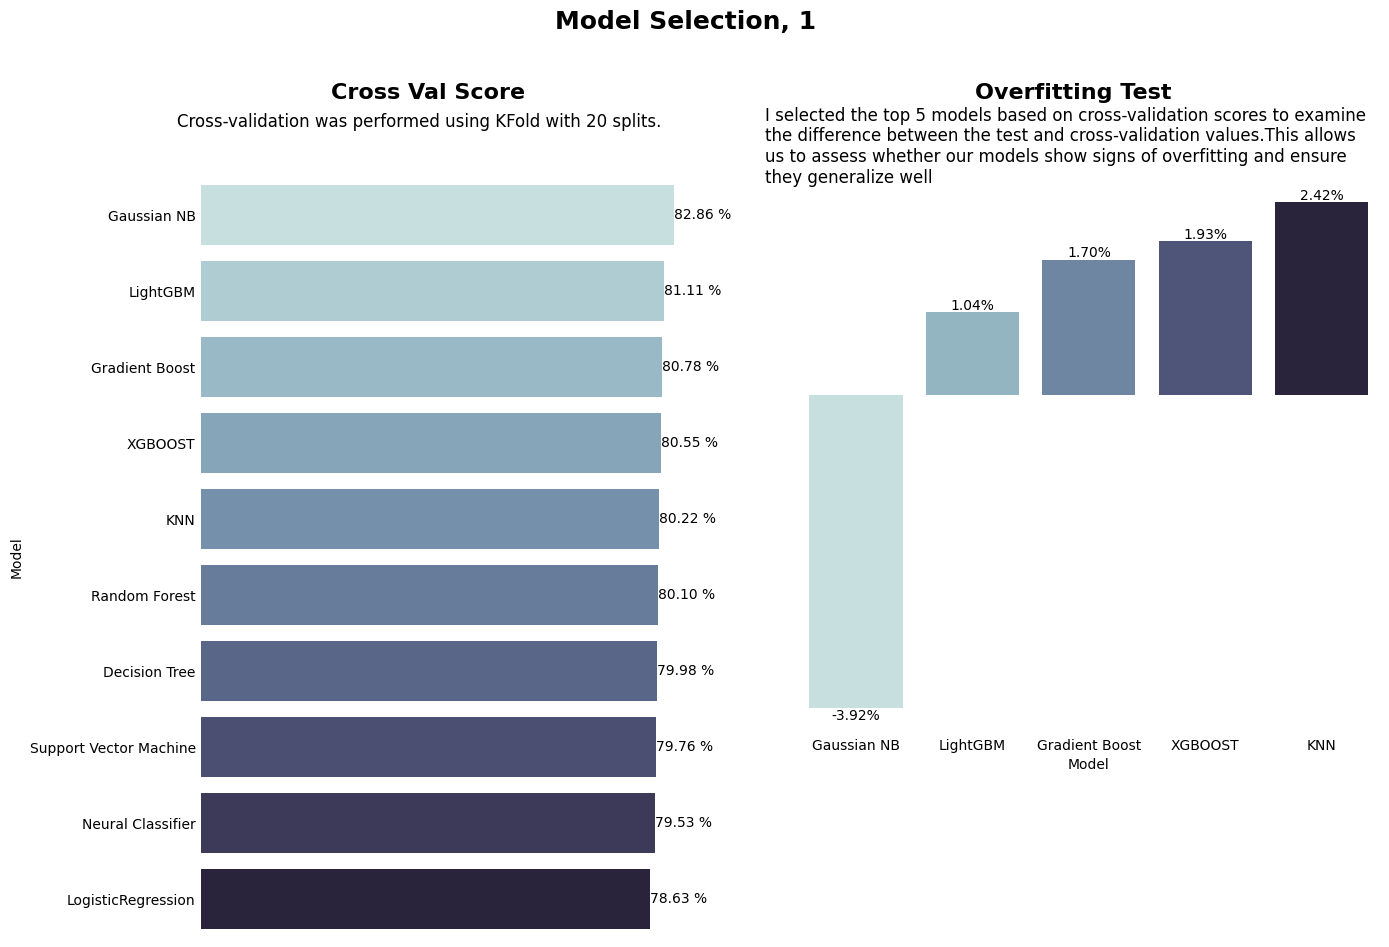

In [45]:
fig = plt.figure(figsize=(14,14))
gs = fig.add_gridspec(14,14)
ax1 = fig.add_subplot(gs[2:10,0:6])
ax2 = fig.add_subplot(gs[2:8,7:14])
axt = [ax1,ax2]
ax1.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
for i in axt:
    for j in ["top","right","bottom","left"]:
        i.spines[j].set_visible(False)
sns.barplot(ax=ax1,y=result1.sort_values(by="CrossValScore",ascending=False)["Model"],x=result1.sort_values(by="CrossValScore",ascending=False)["CrossValScore"],palette="ch:start=.2,rot=-.3")
sns.barplot(x=result1.sort_values(by="CrossValScore",ascending=False).head(5)["Model"],y=result1.sort_values(by="CrossValScore",ascending=False).head(5)["overfittest"],palette="ch:start=.2,rot=-.3")
ax1.tick_params(length=0)
ax2.tick_params(length=0)
fig.text(0.7,0.9,"Overfitting Test",weight="bold",fontsize=16)
fig.text(0.55,0.84,"I selected the top 5 models based on cross-validation scores to examine\nthe difference between the test and cross-validation values.This allows\nus to assess whether our models show signs of overfitting and ensure\nthey generalize well ",fontsize=12)         
fig.text(0.24,0.9,"Cross Val Score",weight="bold",fontsize=16)
fig.text(0.13,0.88,"Cross-validation was performed using KFold with 20 splits.",fontsize=12)
fig.text(0.40,0.95,"Model Selection, 1",weight="bold",fontsize=18)
fig.tight_layout()
for i in ax1.containers:
    ax1.bar_label(i, fmt = lambda x: f'{x*100:.2f} %')
for i in ax2.containers:
    ax2.bar_label(i,fmt = lambda x: f'{x:.2f}%')





C:\Users\Lucas\AppData\Local\Temp\ipykernel_16988\2598718138.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax1,y=result2.sort_values(by="CrossValScore",ascending=False)["Model"],x=result2.sort_values(by="CrossValScore",ascending=False)["CrossValScore"],palette="ch:start=.2,rot=-.3")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_16988\2598718138.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result2.sort_values(by="CrossValScore",ascending=False).head(5)["Model"],y=result2.sort_values(by="CrossValScore",ascending=False).head(5)["overfittest"],palette="ch:start=.2,rot=-.3")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_16988\2598718138.py:15: UserWarning: set_ticklabels() shoul

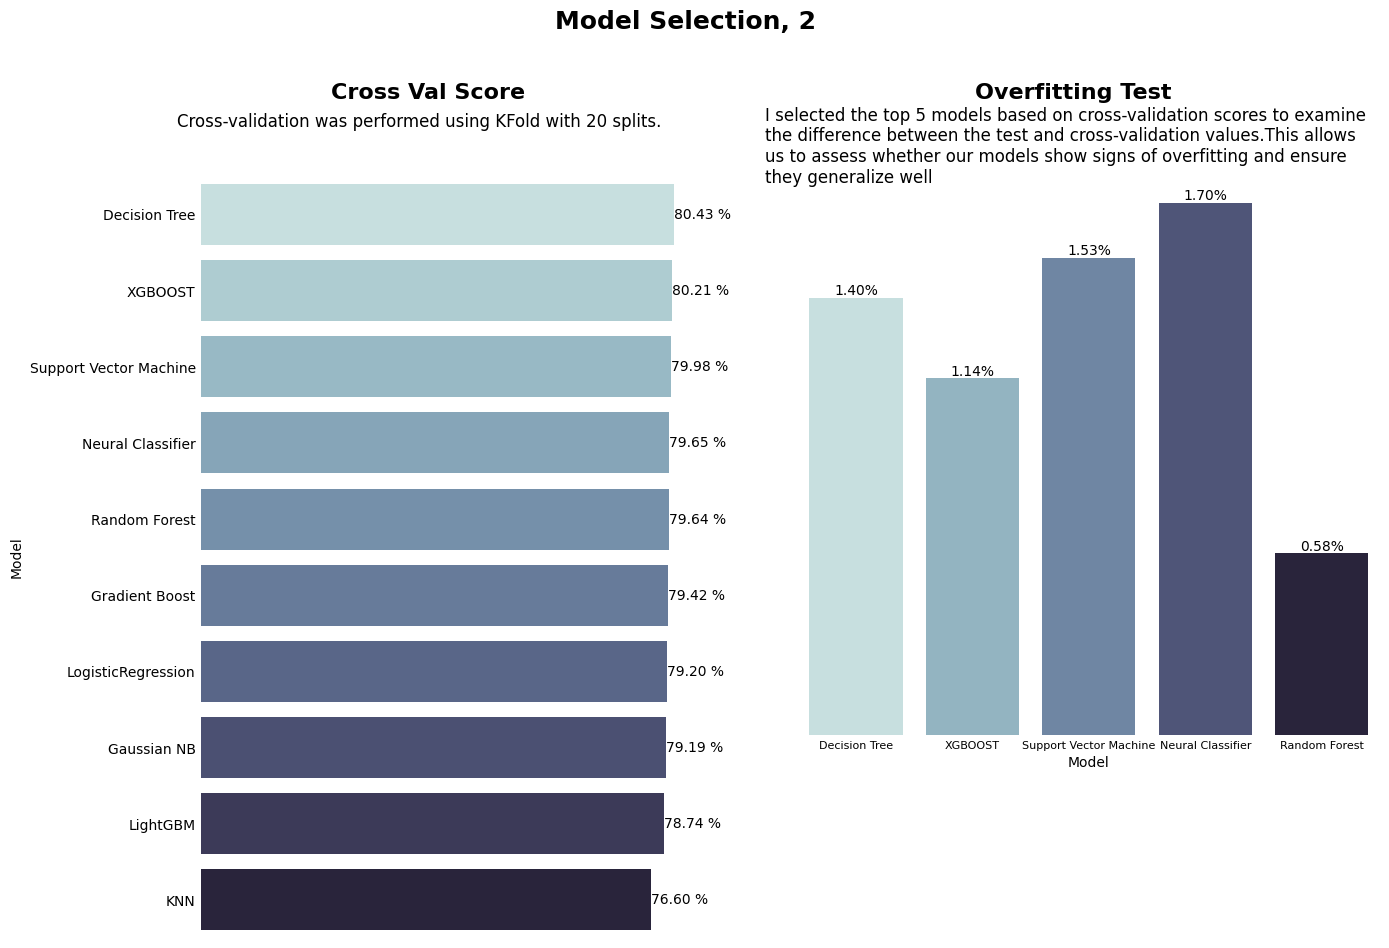

In [46]:
fig = plt.figure(figsize=(14,14))
gs = fig.add_gridspec(14,14)
ax1 = fig.add_subplot(gs[2:10,0:6])
ax2 = fig.add_subplot(gs[2:8,7:14])
axt = [ax1,ax2]
ax1.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
for i in axt:
    for j in ["top","right","bottom","left"]:
        i.spines[j].set_visible(False)
sns.barplot(ax=ax1,y=result2.sort_values(by="CrossValScore",ascending=False)["Model"],x=result2.sort_values(by="CrossValScore",ascending=False)["CrossValScore"],palette="ch:start=.2,rot=-.3")
sns.barplot(x=result2.sort_values(by="CrossValScore",ascending=False).head(5)["Model"],y=result2.sort_values(by="CrossValScore",ascending=False).head(5)["overfittest"],palette="ch:start=.2,rot=-.3")
ax1.tick_params(length=0)
ax2.tick_params(length=0)
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=8)
fig.text(0.7,0.9,"Overfitting Test",weight="bold",fontsize=16)
fig.text(0.55,0.84,"I selected the top 5 models based on cross-validation scores to examine\nthe difference between the test and cross-validation values.This allows\nus to assess whether our models show signs of overfitting and ensure\nthey generalize well ",fontsize=12)         
fig.text(0.24,0.9,"Cross Val Score",weight="bold",fontsize=16)
fig.text(0.13,0.88,"Cross-validation was performed using KFold with 20 splits.",fontsize=12)
fig.text(0.40,0.95,"Model Selection, 2",weight="bold",fontsize=18)
fig.tight_layout()
for i in ax1.containers:
    ax1.bar_label(i, fmt = lambda x: f'{x*100:.2f} %')
for i in ax2.containers:
    ax2.bar_label(i,fmt = lambda x: f'{x:.2f}%')


C:\Users\Lucas\AppData\Local\Temp\ipykernel_16988\2660107777.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax1,y=result3.sort_values(by="CrossValScore",ascending=False)["Model"],x=result3.sort_values(by="CrossValScore",ascending=False)["CrossValScore"],palette="ch:start=.2,rot=-.3")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_16988\2660107777.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=result3.sort_values(by="CrossValScore",ascending=False).head(5)["Model"],y=result3.sort_values(by="CrossValScore",ascending=False).head(5)["overfittest"],palette="ch:start=.2,rot=-.3")


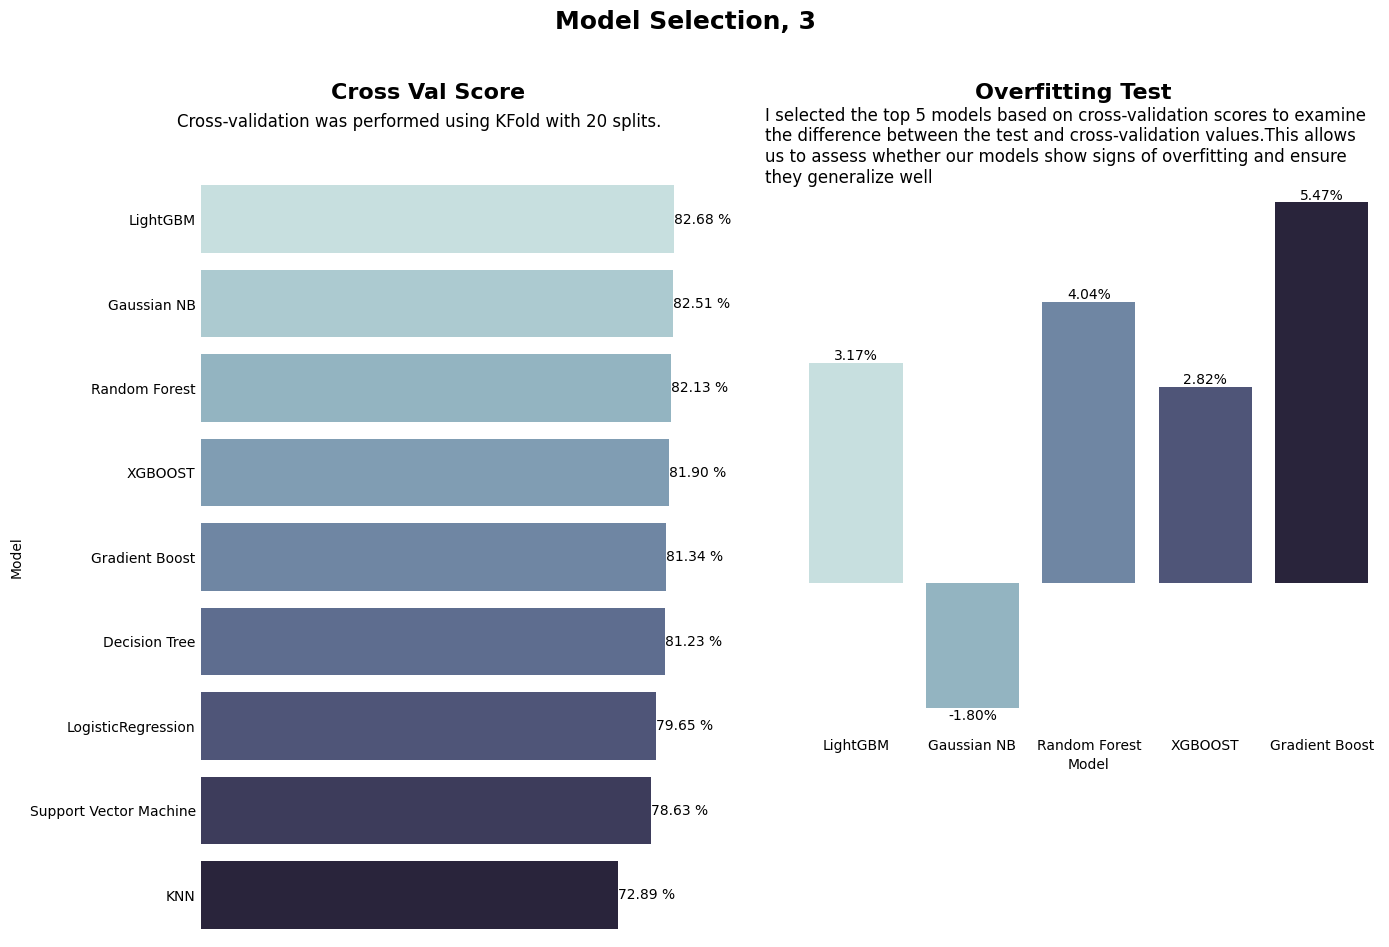

In [47]:
fig = plt.figure(figsize=(14,14))
gs = fig.add_gridspec(14,14)
ax1 = fig.add_subplot(gs[2:10,0:6])
ax2 = fig.add_subplot(gs[2:8,7:14])
axt = [ax1,ax2]
ax1.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
for i in axt:
    for j in ["top","right","bottom","left"]:
        i.spines[j].set_visible(False)
sns.barplot(ax=ax1,y=result3.sort_values(by="CrossValScore",ascending=False)["Model"],x=result3.sort_values(by="CrossValScore",ascending=False)["CrossValScore"],palette="ch:start=.2,rot=-.3")
sns.barplot(x=result3.sort_values(by="CrossValScore",ascending=False).head(5)["Model"],y=result3.sort_values(by="CrossValScore",ascending=False).head(5)["overfittest"],palette="ch:start=.2,rot=-.3")
ax1.tick_params(length=0)
ax2.tick_params(length=0)
fig.text(0.7,0.9,"Overfitting Test",weight="bold",fontsize=16)
fig.text(0.55,0.84,"I selected the top 5 models based on cross-validation scores to examine\nthe difference between the test and cross-validation values.This allows\nus to assess whether our models show signs of overfitting and ensure\nthey generalize well ",fontsize=12)         
fig.text(0.24,0.9,"Cross Val Score",weight="bold",fontsize=16)
fig.text(0.13,0.88,"Cross-validation was performed using KFold with 20 splits.",fontsize=12)
fig.text(0.40,0.95,"Model Selection, 3",weight="bold",fontsize=18)
fig.tight_layout()
for i in ax1.containers:
    ax1.bar_label(i, fmt = lambda x: f'{x*100:.2f} %')
for i in ax2.containers:
    ax2.bar_label(i,fmt = lambda x: f'{x:.2f}%')


After conducting the experiments, we identified that the best performing models were LightGBM and Gaussian Naive Bayes. However, upon analyzing the configurations of the three predictor sets created (Predict1, Predict2, and Predict3), we observed that Predict2 performed worse, making it less attractive for practical use.

**Why did Predict2 perform worse??**

The lower performance of Predict2 may be attributed to the lack of scaling for the SibSp and Parch variables. These variables, without proper treatment, may have been given more weight than ideal in the model, negatively impacting the results. Additionally, using LabelEncoder on Sex and Embarked instead of OneHotEncoder may have reduced the representativeness of these categorical variables, especially in models sensitive to the ordinal relationships that LabelEncoder may mistakenly infer.
In contrast, Predict1, which included more detailed and consistent preprocessing, yielded better results for the models.

**Purpose of Final Selection**

Our goal is to determine whether the models are achieving high accuracy because they are correctly identifying survivors, or if they are simply prioritizing the majority class (deaths). Since the survivors' class is minority in the Titanic dataset, it is crucial to ensure that the models are effective at capturing the patterns of both classes, especially in applications where correctly identifying survivors is prioritized.

Based on the results of this analysis, we will be able to determine which combination of model and predictor set is most suitable, depending on the practical objective—whether it is to prioritize identifying survivors or reduce false positives.

# Final Selection

In [48]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score

In [49]:
x_train,x_test,y_train,y_test = train_test_split(predict1,target,test_size=0.3,random_state=0)
gb = GaussianNB()
gb.fit(x_train,y_train)
y_predgb = gb.predict(x_test)
x_train,x_test,y_train,y_test = train_test_split(predict3,target,test_size=0.3,random_state=0)
lgb = lightgbm.LGBMClassifier(learning_rate=0.006,max_depth=3,n_estimators=474,num_leaves=10,random_state=0,verbose=-1)
lgb.fit(x_train,y_train)
y_predlgb = lgb.predict(x_test)

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, y_predgb)


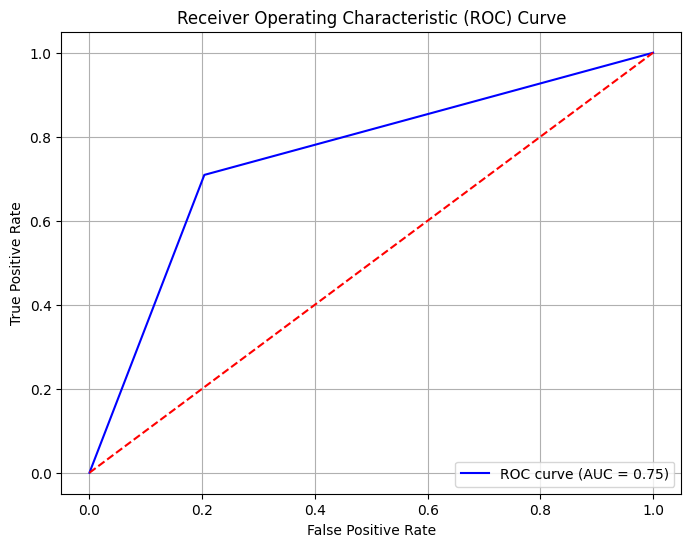

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_predgb)
auc = roc_auc_score(y_test,y_predgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Linha de referência
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


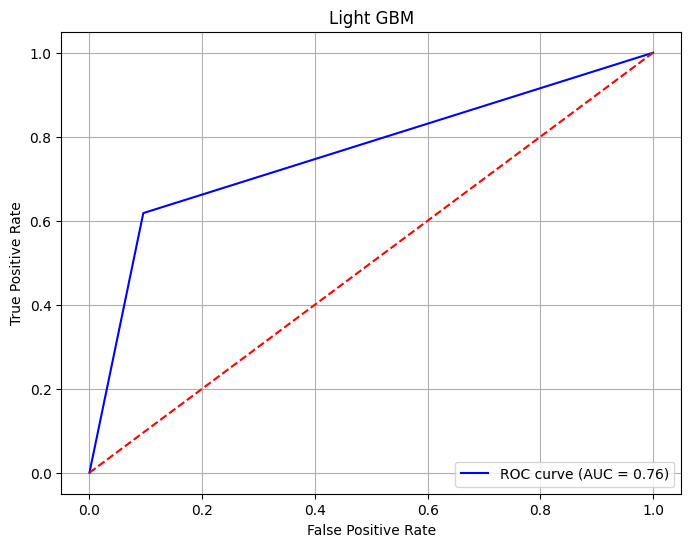

In [52]:
fpr,tpr,thresholds = roc_curve(y_test,y_predlgb)
rocauc = roc_auc_score(y_test,y_predlgb)
fig = plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='blue',label=f"ROC curve (AUC = {rocauc:.2f})")
plt.plot([0,1],[0,1],color='red',linestyle='dashed')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Light GBM")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [53]:
print(classification_report(y_true=y_test,y_pred=y_predgb))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       157
           1       0.71      0.71      0.71       110

    accuracy                           0.76       267
   macro avg       0.75      0.75      0.75       267
weighted avg       0.76      0.76      0.76       267



In [54]:
confusion_matrix(y_true=y_test,y_pred=y_predgb)

array([[125,  32],
       [ 32,  78]], dtype=int64)

In [55]:
print(classification_report(y_true=y_test,y_pred=y_predlgb))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       157
           1       0.82      0.62      0.70       110

    accuracy                           0.79       267
   macro avg       0.80      0.76      0.77       267
weighted avg       0.79      0.79      0.78       267



In [56]:
confusion_matrix(y_true=y_test,y_pred=y_predlgb)

array([[142,  15],
       [ 42,  68]], dtype=int64)

Based on the analyzed metrics, it is evident that the LightGBM model exhibits a more conservative behavior. It tends to make more errors when predicting the "0" class (non-survivors), being less effective at correctly identifying people who survived. This happens because the model prioritizes predicting "someone died" rather than "someone survived." Since the survival class is minority (there are significantly more deaths than survivors in the dataset), LightGBM may achieve higher accuracy when considering the entire dataset but with a limitation in identifying survivors.

On the other hand, the Gaussian Naive Bayes (GaussianNB) model stands out for its ability to more accurately identify people who survived. The choice between these models should depend on the application's objective. If the goal is to identify all survivors, even at the cost of some false positives (error in classifying someone as a survivor when they are not), GaussianNB would be more suitable. On the other hand, if the goal is to identify non-survivors with higher precision, minimizing false positives (error in classifying someone as a survivor when they actually died), LightGBM would be the more appropriate choice.

**Decision in a Real-World Context**

In a real-world scenario, such as rescue operations or prioritizing resources for survivors, the focus is usually on minimizing the risk of leaving survivors unidentified. In this case, prioritizing the GaussianNB model would be more advantageous because it is preferable to direct additional efforts towards searching for survivors, even at the cost of dealing with some false positives. On the other hand, if the goal is to reduce costs or unnecessary efforts, focusing on precision to identify fatalities, LightGBM could be more useful.

**ROC Curve Analysis**

The ROC curve provides valuable insights into the performance of both models across different decision thresholds. Initially, with a small cost in terms of false positives, LightGBM performs better. This means that, in situations where predicting a limited number of survivors and minimizing false positives (e.g., reducing operational efforts) is crucial, LightGBM is an interesting choice.

However, as the threshold increases and the number of false positives grows, GaussianNB shows a steeper incline in the ROC curve, indicating that it performs better in scenarios where it is acceptable to handle more false positives to maximize survivor detection. Therefore, if the goal is to increase the coverage of identified survivors, even at the cost of more false positives, GaussianNB becomes the more appropriate choice.

**Conclusão**

The decision on which model to use depends directly on the problem's purpose and the practical implications of each error (false positives and false negatives). In the Titanic context, where saving lives would be the priority, GaussianNB proves to be more effective as it increases the probability of identifying survivors. However, in applications where the cost of false positives is critical, LightGBM might be the ideal option.